# Datensatz-Vorbereitung

### Imports und Datei

In [2]:
import osmium as osm
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import networkx as nx
import seaborn as sns
import numpy as np
import os
import requests
from collections import Counter, defaultdict
from math import radians, cos, sin, asin, sqrt
import xml.etree.ElementTree as ET
from matplotlib.lines import Line2D
import random
import time

# Setze den Pfad zum Dataset
dataset_path = os.path.join("Datasets", "unterfranken-latest.osm")
cities = ["Ringheim", "Mömlingen", "Glattbach", "Großostheim", "Marktheidenfeld", "Aschaffenburg", "Würzburg"]  

### Daten in XML-Datei speichern

In [ ]:
def save_to_xml(df, city_name, addresstype):
    root = ET.Element("osm", version="0.6", generator="Bachelorproject")
    
    # Knoten hinzufügen
    for _, row in df[df['type'] == 'node'].iterrows():
        node = ET.SubElement(root, "node", id=str(row['id']),
                             visible=str(row['visible']),
                             lat=str(row['latitude']),
                             lon=str(row['longitude']))
        if row['tagkey']:
            ET.SubElement(node, "tag", k=row['tagkey'], v=row['tagvalue'])
    
    # Wege hinzufügen
    for _, row in df[df['type'] == 'way'].iterrows():
        way_attrs = {
            "id": str(row['id']),
            "visible": str(row['visible'])
        }
        # Wenn eine Länge vorhanden ist, als Attribut hinzufügen
        if 'length' in row and pd.notna(row['length']):
            way_attrs['length'] = str(row['length'])
        
        way = ET.SubElement(root, "way", **way_attrs)
        
        for node_id in row['node_ids']:
            ET.SubElement(way, "nd", ref=str(node_id))
        
        if row['tagkey']:
            ET.SubElement(way, "tag", k=row['tagkey'], v=row['tagvalue'])

    # XML-Baum erstellen und speichern
    city_folder = os.path.join("City_data", addresstype)
    os.makedirs(city_folder, exist_ok=True)
    
    tree = ET.ElementTree(root)
    file_path = os.path.join(city_folder, f"{city_name}.osm")
    tree.write(file_path, encoding="utf-8", xml_declaration=True)
    print(f"Datei erfolgreich gespeichert: {file_path}")

### Daten aus der XML-Datei lesen

In [3]:
def load_from_xml(city_name, addresstype):
    file_path = os.path.join("City_data", addresstype,f"{city_name}.osm")
    tree = ET.parse(file_path)
    root = tree.getroot()

    osm_data = []

    # Knoten extrahieren
    for node in root.findall("node"):
        node_id = int(node.get("id"))
        lon = float(node.get("lon"))
        lat = float(node.get("lat"))
        osm_data.append(["node", node_id, True, 0, None, None, lon, lat, None])

    # Wege extrahieren
    for way in root.findall("way"):
        way_id = int(way.get("id"))
        node_ids = [int(nd.get("ref")) for nd in way.findall("nd")]
        for tag in way.findall("tag"):
            tagkey = tag.get("k")
            tagvalue = tag.get("v")
            osm_data.append(["way", way_id, True, len(way.findall("tag")), tagkey, tagvalue, None, None, node_ids])

    # DataFrame erstellen
    columns = ['type', 'id', 'visible', 'ntags', 'tagkey', 'tagvalue', 'longitude', 'latitude', 'node_ids']
    return pd.DataFrame(osm_data, columns=columns)

def load_from_xml_with_length(city_name, addresstype):
    file_path = os.path.join("City_data", addresstype,f"{city_name}.osm")
    tree = ET.parse(file_path)
    root = tree.getroot()

    osm_data = []

    # Knoten extrahieren
    for node in root.findall("node"):
        node_id = int(node.get("id"))
        lon = float(node.get("lon"))
        lat = float(node.get("lat"))
        osm_data.append(["node", node_id, True, 0, None, None, lon, lat, None])

    # Wege extrahieren
    for way in root.findall("way"):
        way_id = int(way.get("id"))
        node_ids = [int(nd.get("ref")) for nd in way.findall("nd")]
        length = way.get("length")  
        length = float(length) if length else None  
        for tag in way.findall("tag"):
            tagkey = tag.get("k")
            tagvalue = tag.get("v")
            osm_data.append(["way", way_id, True, len(way.findall("tag")), tagkey, tagvalue, None, None, node_ids, length])

    # DataFrame erstellen
    columns = ['type', 'id', 'visible', 'ntags', 'tagkey', 'tagvalue', 'longitude', 'latitude', 'node_ids', 'length']
    return pd.DataFrame(osm_data, columns=columns)

def load_from_all_xml(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()

    osm_data = []

    # Knoten extrahieren
    for node in root.findall("node"):
        node_id = int(node.get("id"))
        lon = float(node.get("lon"))
        lat = float(node.get("lat"))
        osm_data.append(["node", node_id, True, 0, None, None, lon, lat, None])

    # Wege extrahieren
    for way in root.findall("way"):
        way_id = int(way.get("id"))
        node_ids = [int(nd.get("ref")) for nd in way.findall("nd")]
        length = way.get("length")  
        length = float(length) if length else None  
        for tag in way.findall("tag"):
            tagkey = tag.get("k")
            tagvalue = tag.get("v")
            osm_data.append(["way", way_id, True, len(way.findall("tag")), tagkey, tagvalue, None, None, node_ids, length])

    # DataFrame erstellen
    columns = ['type', 'id', 'visible', 'ntags', 'tagkey', 'tagvalue', 'longitude', 'latitude', 'node_ids', 'length']
    return pd.DataFrame(osm_data, columns=columns)

### Haversine-Formel

In [ ]:
def haversine(lon1, lat1, lon2, lat2):
    # Dezimalzahlen in Radianten umwandeln
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # Haversine Formel
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius der Erde in Kilometer
    return c * r * 1000

### Straßenlängen berechnen

In [ ]:
# Straßenlänge berechnen
def calculate_full_road_length(way_row, df_nodes):
    node_ids = way_row['node_ids']
    total_length = 0

    for i in range(len(node_ids) - 1):
        first_node = df_nodes[df_nodes['id'] == node_ids[i]]
        second_node = df_nodes[df_nodes['id'] == node_ids[i + 1]]

        # Überprüfung, ob beide Knoten existieren
        if first_node.empty or second_node.empty:
            return None

        total_length += haversine(
            first_node['longitude'].values[0], first_node['latitude'].values[0],
            second_node['longitude'].values[0], second_node['latitude'].values[0]
        )

    return total_length

### Kreuzungsknoten erhalten

In [ ]:
def filter_intersection_nodes(df):
    all_node_ids = []
    for node_ids_list in df[df['type'] == 'way']['node_ids']:
        if node_ids_list is not None:
            all_node_ids.extend(node_ids_list)

    node_reference_count = Counter(all_node_ids)
    nodes_referenced_multiple = {node_id for node_id, count in node_reference_count.items() if count > 1}

    df_nodes_filtered_multiple = df[(df['type'] == 'node') & (df['id'].isin(nodes_referenced_multiple))]

    filtered_data_multiple = pd.concat([df[df['type'] == 'way'], df_nodes_filtered_multiple], ignore_index=True)

    return filtered_data_multiple

### Knoten vom Grad 2 entfernen

#### Funktionen für die Bearbeitung der Grad 2 Knoten

In [ ]:
neighbors_found = {}

# Entfernen von Knoten mit Grad 2 aus den node-ids
def remove_degree_2_nodes(node_ids, degree_2_node_ids):
    if node_ids is not None:
        return [node_id for node_id in node_ids if node_id not in degree_2_node_ids]
    return node_ids

# 2 Grad-3+-Nachbarn finden
def find_neighbors_with_degree_3(G, node_id, visited=None, found_neighbors=None):    
    if visited is None:
        visited = set()
    if found_neighbors is None:
        found_neighbors = []

    visited.add(node_id)
    neighbors = list(G.neighbors(node_id))

    for neighbor in neighbors:
        if neighbor not in visited:
            neighbor_degree = G.degree(neighbor)

            # Füge Nachbarn hinzu, wenn er Grad 3 oder höher hat
            if neighbor_degree >= 3:
                found_neighbors.append(neighbor)

                if node_id not in neighbors_found:
                    neighbors_found[node_id] = []
                neighbors_found[node_id].append(neighbor)

                # Stoppe, wenn zwei passende Nachbarn gefunden wurden
                if len(found_neighbors) == 2:
                    return found_neighbors

            # Rekursive Suche fortsetzen, wenn der Nachbar Grad 2 hat
            elif neighbor_degree == 2:
                result = find_neighbors_with_degree_3(G, neighbor, visited, found_neighbors)
                if len(result) == 2:
                    return result
                
    return found_neighbors

# Aktualisieren der node_ids der Straßen, die Knoten mit Grad 2 enthalten
def update_node_ids(G, row, degree_2_node_ids, ways_filter):
    node_ids = row['node_ids']
    if node_ids is not None:
        updated_node_ids = list(node_ids)
        for node_id in node_ids:
            if node_id in degree_2_node_ids:
                # Finde Nachbarn des Knotens mit Grad 2
                neighbors = find_neighbors_with_degree_3(G, node_id)
                if len(neighbors) == 2:
                    neighbor_1, neighbor_2 = neighbors

                    # Finde die zwei Straßen, die den Grad-2-Knoten referenzieren
                    referencing_ways = ways_filter[ways_filter['node_ids'].apply(lambda x: node_id in x)]

                    if len(referencing_ways) == 2:
                        way_1, way_2 = referencing_ways.iloc[0], referencing_ways.iloc[1]

                        # Kopiere die Node-IDs als Listen
                        way_1_node_ids = list(way_1['node_ids']) if isinstance(way_1['node_ids'], list) else way_1['node_ids']
                        way_2_node_ids = list(way_2['node_ids']) if isinstance(way_2['node_ids'], list) else way_2['node_ids']

                        # Füge Nachbarn hinzu, falls sie nicht bereits vorhanden sind
                        if neighbor_1 not in way_2_node_ids:
                            way_2_node_ids.append(neighbor_1)
                        if neighbor_1 not in way_1_node_ids:
                            way_1_node_ids.append(neighbor_1)

                        # Aktualisiere die DataFrame-Zeilen
                        ways_filter.at[way_1.name, 'node_ids'] = way_1_node_ids
                        ways_filter.at[way_2.name, 'node_ids'] = way_2_node_ids

        # Stelle sicher, dass die Rückgabewerte korrekt sind
        return updated_node_ids if updated_node_ids else None
    return node_ids

#### Funktionen für die Bearbeitung der speziellen Grad-2-Knoten

In [ ]:
def handle_special_degree_2_nodes(special_nodes, connected_ways, ways_filter, G):
    neighbors_by_special_node = {}

    def find_special_neighbors(node_id, connected_node_ids, visited=None, found_neighbors=None):
        if visited is None:
            visited = set()
        if found_neighbors is None:
            found_neighbors = set()

        visited.add(node_id)
        neighbors = list(G.neighbors(node_id))

        for neighbor in neighbors:
            if neighbor not in visited and neighbor in connected_node_ids:  
                neighbor_degree = G.degree(neighbor)

                # Füge Nachbarn hinzu, wenn er Grad 3 oder höher hat
                if neighbor_degree >= 3:
                    found_neighbors.add(neighbor) 

                    # Stoppe, wenn zwei passende Nachbarn gefunden wurden
                    if len(found_neighbors) == 2:
                        return list(found_neighbors)

                # Rekursive Suche fortsetzen, wenn der Nachbar Grad 2 hat
                elif neighbor_degree == 2:
                    result = find_special_neighbors(neighbor, connected_node_ids, visited, found_neighbors)
                    if len(result) == 2:
                        return list(result)

        return list(found_neighbors)

    # Für jeden speziellen Knoten die Nachbarn durch verbundene Wege finden
    for node_id, ways in connected_ways.items():
        neighbors_by_special_node[node_id] = []
        connected_node_ids = set()
        for way_id in ways:
            way = ways_filter[ways_filter['id'] == way_id]
            if not way.empty:
                connected_node_ids.update(way.iloc[0]['node_ids'])

        # Suche Nachbarn des speziellen Knotens, die Grad 3+ haben und in connected_node_ids liegen
        neighbors = find_special_neighbors(node_id, connected_node_ids)
        if neighbors:
            neighbors_by_special_node[node_id].extend(neighbors)

    return neighbors_by_special_node

# Identifizieren der speziellen Grad-2-Knoten
def identify_special_degree_2_nodes(node_way_mapping):
    special_nodes = {node_id: ways for node_id, ways in node_way_mapping.items() if len(ways) > 2}
    return special_nodes

# Ermitteln der Straßen, die mit speziellen Grad-2-Knoten verbunden sind
def get_connected_ways_for_special_nodes(df_special_nodes, valid_ways, G):
    connected_ways_by_node = {}

    for _, node_row in df_special_nodes.iterrows():
        node_id = node_row['id']
        connected_ways_by_node[node_id] = []
        
        # Finde Wege, die mit diesem speziellen Knoten verbunden sind
        for _, way_row in valid_ways.iterrows():
            way_id = way_row['id']
            node_ids_list = way_row['node_ids']
            
            if node_id in node_ids_list:
                # Prüfen, ob die Knoten des Wegs im Graphen existieren
                for i in range(len(node_ids_list) - 1):
                    u, v = node_ids_list[i], node_ids_list[i + 1]
                    if G.has_edge(u, v):
                        connected_ways_by_node[node_id].append(way_id)
                        break

    return connected_ways_by_node

# Aktualisieren der node_ids für spezielle Knoten
def update_special_node_ids(row, special_nodes, neighbors_by_special_node, connected_ways_for_special_nodes, ways_filter):
    node_ids = row['node_ids']

    if not isinstance(node_ids, list):
        node_ids = []
    
    if node_ids:
        updated_node_ids = list(node_ids)
        
        for node_id in node_ids:
            if node_id in special_nodes:
                neighbors = neighbors_by_special_node.get(node_id, [])
        
                if len(neighbors) == 2:
                    neighbor_1, neighbor_2 = neighbors
                    referencing_ways = connected_ways_for_special_nodes.get(node_id, [])
                    if len(referencing_ways) == 2:
                        way_1_id, way_2_id = referencing_ways[0], referencing_ways[1]
                        
                        way_1 = ways_filter[ways_filter['id'] == way_1_id].iloc[0]
                        way_2 = ways_filter[ways_filter['id'] == way_2_id].iloc[0]

                        way_1_node_ids = list(way_1['node_ids']) if isinstance(way_1['node_ids'], list) else way_1['node_ids']
                        way_2_node_ids = list(way_2['node_ids']) if isinstance(way_2['node_ids'], list) else way_2['node_ids']

                        if neighbor_1 not in way_2_node_ids:
                            way_2_node_ids.append(neighbor_1)
                        if neighbor_1 not in way_1_node_ids:
                            way_1_node_ids.append(neighbor_1)

                        ways_filter.at[way_1.name, 'node_ids'] = way_1_node_ids
                        ways_filter.at[way_2.name, 'node_ids'] = way_2_node_ids
        
        return updated_node_ids if updated_node_ids else None
    
    return node_ids

# Entfernen der speziellen und normalen Knoten
def remove_special_nodes_from_ids(node_ids, special_node_ids):
    if node_ids is not None:
        return [node_id for node_id in node_ids if node_id not in special_node_ids]
    return node_ids

#### Aufruf zum Entfernen der Grad-2-Knoten

In [ ]:
def remove_degree_2_nodes_from_file(df, ways_filter):
    # Extrahieren der Knoten_Ids
    existing_node_ids = set(df[df['type'] == 'node']['id'])

    G = nx.Graph()
    for index, row in df[df['type'] == 'node'].iterrows():  
        G.add_node(row['id'], pos=(row['longitude'], row['latitude']))

    # Wege durchgehen und Kanten im Graphen hinzufügen
    for _, row in df[df['type'] == 'way'].iterrows():
        node_ids = row['node_ids']
        if node_ids is not None:
            valid_node_ids = [node_id for node_id in node_ids if node_id in existing_node_ids]
            for i in range(len(valid_node_ids) - 1):
                G.add_edge(valid_node_ids[i], valid_node_ids[i + 1])

    # Knoten mit Grad 2 finden
    node_degrees = dict(G.degree())
    nodes_with_degree_2 = [node_id for node_id, degree in node_degrees.items() if degree == 2]

    # Knoten mit Grad 2 in filtered_data_multiple filtern
    df_nodes_degree_2 = df[(df['type'] == 'node') & (df['id'].isin(nodes_with_degree_2))]
    degree_2_node_ids = set(df_nodes_degree_2['id'])

    # Spezielle Knoten mit Grad 2 finden
    nodes_degree_2 = [node for node, degree in G.degree() if degree == 2]
    node_way_mapping = {node_id: [] for node_id in nodes_degree_2}
    for index, way in df[df['type'] == 'way'].iterrows():
        node_ids_list = way['node_ids']
        if node_ids_list is not None:
            for node_id in nodes_degree_2:
                if node_id in node_ids_list:
                    node_way_mapping[node_id].append(way['id'])
    special_nodes = identify_special_degree_2_nodes(node_way_mapping)

    # Datensatz für spezielle Knoten
    special_node_ids = set(special_nodes.keys()) 
    df_special_nodes = df[df['id'].isin(special_node_ids)]

    # Straßen mit speziellen Knoten ermitteln
    connected_ways_for_special_nodes = get_connected_ways_for_special_nodes(df_special_nodes, df[df['type'] == 'way'], G)

    # Nachbarn von speziellen Knoten ermitteln
    neighbors_by_special_node = handle_special_degree_2_nodes(df_special_nodes, connected_ways_for_special_nodes, ways_filter, G)

    # Aktualisieren die node_ids der speziellen Straßen
    df['node_ids'] = df.apply(lambda row: update_special_node_ids(row, special_nodes, neighbors_by_special_node, connected_ways_for_special_nodes, ways_filter), axis=1)

    # Aktualisiere die node_ids der Straßen
    df['node_ids'] = df.apply(lambda row: update_node_ids(G, row, degree_2_node_ids, ways_filter), axis=1)

    # Entfernen der Knoten mit Grad 2 aus den node_ids der Straßen
    df['node_ids'] = df['node_ids'].apply(lambda node_ids: remove_special_nodes_from_ids(node_ids, degree_2_node_ids.union(special_node_ids)))

    # Entferne Knoten mit Grad 2 aus dem Datensatz
    df = df[~df['id'].isin(degree_2_node_ids.union(special_node_ids))]

    G.remove_nodes_from(nodes_with_degree_2)

    # Entferne unverbundene Knoten aus dem Datensatz
    connected_nodes = set(G.nodes)
    df = df[(df['type'] != 'node') | (df['id'].isin(connected_nodes))]
    isolated_nodes = [node for node, degree in G.degree() if degree == 0]
    df = df[~((df['type'] == 'node') & (df['id'].isin(isolated_nodes)))]

    return df

### Knoten zusammenfügen, die nah beieinander stehen

In [ ]:
def process_merging(df, max_distance=5):
    df_nodes = df[df['type'] == 'node']
    df_ways = df[df['type'] == 'way']

    merged_nodes, node_merge_dict = merge_within_distance(df_nodes, max_distance)
    df_merged_nodes = pd.DataFrame(merged_nodes, columns=['id', 'longitude', 'latitude'])

    # Wege aktualisieren
    df_ways['node_ids'] = df_ways['node_ids'].apply(
        lambda x: update_node_ids_merged(x, node_merge_dict)
    )
    # Ehemalige Knoten entfernen
    df_nodes_updated = remove_replaced_nodes(df_nodes, node_merge_dict)

    df_nodes_final = pd.concat([df_nodes_updated, df_merged_nodes], ignore_index=True)

    # Doppelte und leere Knoten-IDs entfernen
    df_ways = df_ways[df_ways['node_ids'].apply(lambda x: len(x) > 1)]

    df_city_data_updated = pd.concat([df_nodes_final, df_ways], ignore_index=True)

    return df_city_data_updated

    # Löschen der Knoten, die durch anderen ersetzt wurde
def remove_replaced_nodes(df_nodes, node_merge_dict):
    replaced_node_ids = set(node_merge_dict.keys()) - set(node_merge_dict.values())
    return df_nodes[~df_nodes['id'].isin(replaced_node_ids)]

# Aktualisiere node_ids
def update_node_ids_merged(node_ids, node_merge_dict):
    if node_ids is not None and isinstance(node_ids, list):
        updated_node_ids = [node_merge_dict.get(node_id, node_id) for node_id in node_ids]
        # Entferne doppelte Knoten, falls sie durch das Zusammenführen entstanden sind
        unique_node_ids = list(dict.fromkeys(updated_node_ids))
        return unique_node_ids
    return node_ids

# Zusammenfügen der Knoten, die nah beieinander stehen
def merge_within_distance(df_nodes, max_distance):
    merged_nodes = []
    node_merge_dict = {}
    seen = set()

    for i, node_1 in df_nodes.iterrows():
        for j, node_2 in df_nodes.iterrows():
            # Vergleich gleicher Knoten verhindern
            if node_1['id'] == node_2['id'] or node_1['id'] in seen or node_2['id'] in seen:
                continue

            lon1, lat1 = node_1['longitude'], node_1['latitude']
            lon2, lat2 = node_2['longitude'], node_2['latitude']

            distance = haversine(lon1, lat1, lon2, lat2)

            if distance < max_distance:
                merged_node = {
                    'id': node_1['id'],
                    'longitude': (lon1 + lon2) / 2,
                    'latitude': (lat1 + lat2) / 2
                }
                merged_nodes.append(merged_node)

                # Knoten als gesehen markiert
                seen.add(node_1['id'])
                seen.add(node_2['id'])

                node_merge_dict[node_2['id']] = node_1['id']

    return merged_nodes, node_merge_dict

### Isolierte Knoten entfernen

In [ ]:
def remove_isolated_nodes(df):
    G = nx.Graph()

    for index, row in df[df['type'] == 'node'].iterrows():  
        G.add_node(row['id'], pos=(row['longitude'], row['latitude']))

    for index, way in df[df['type'] == 'way'].iterrows():
        node_ids_list = way['node_ids']
        if node_ids_list is not None:
            filtered_node_ids_list = [node_id for node_id in node_ids_list if G.has_node(node_id)]
            if len(filtered_node_ids_list) > 1:
                for i in range(len(filtered_node_ids_list) - 1):
                    G.add_edge(filtered_node_ids_list[i], filtered_node_ids_list[i + 1])

    connected_nodes = set(G.nodes)
    df = df[(df['type'] != 'node') | (df['id'].isin(connected_nodes))]
    isolated_nodes = [node for node, degree in G.degree() if degree == 0]
    df = df[~((df['type'] == 'node') & (df['id'].isin(isolated_nodes)))]

    return df

### Alle Daten aus dem Datensatz auslesen

In [ ]:
class OSMHandler(osm.SimpleHandler):
    def __init__(self):
        osm.SimpleHandler.__init__(self)
        self.osm_data = []

    def tag_inventory(self, elem, elem_type, lon=None, lat=None, node_ids=None):
        if len(elem.tags) == 0:
            # Für Knoten ohne Tags
            self.osm_data.append([elem_type, 
                                  elem.id, 
                                  elem.visible,
                                  0, 
                                  None, 
                                  None, 
                                  lon, 
                                  lat, 
                                  node_ids])
        else:
            for tag in elem.tags:
                self.osm_data.append([elem_type, 
                                      elem.id,
                                      elem.visible,
                                      len(elem.tags),
                                      tag.k, 
                                      tag.v, lon, lat, node_ids])

    def node(self, n):
        self.tag_inventory(n, "node", lon=n.location.lon, lat=n.location.lat)

    def way(self, w):
        node_ids = [n.ref for n in w.nodes]  
        self.tag_inventory(w, "way", node_ids=node_ids)

# Daten auslesen
osmhandler = OSMHandler()
osmhandler.apply_file(dataset_path)

# DataFrame erstellen
data_colnames = ['type', 'id', 'visible', 'ntags', 'tagkey', 'tagvalue', 'longitude', 'latitude', 'node_ids']
df_osm = pd.DataFrame(osmhandler.osm_data, columns=data_colnames)
df_osm

### Datensatz nach Wegen gefiltert

In [ ]:
ways_filter = df_osm[(df_osm['type'] == 'way') & (df_osm['tagkey'] == 'highway')]
ways_filter

In [ ]:
ways_maxspeed = df_osm[(df_osm['type'] == 'way') & (df_osm['tagkey'] == 'maxspeed')]
ways_maxspeed

### API-Anfrage für die Längen- und Breitengrade der Städte

In [ ]:
# API-Anfrage um Bounding Box der Stadt zu bekommen
def get_bounding_box(city_name):
    url = f"https://nominatim.openstreetmap.org/search?city={city_name}&format=json"
    headers = {
        "User-Agent": "Bachelorproject/1.0"
    }
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        results = response.json()
        for result in results:
            if result.get("osm_type") in ["node", "relation"]:
                if result.get("addresstype") in ["village", "town", "city"] and 'boundingbox' in result:
                    display_name = result.get("display_name", "")
                    if 'Baden-Württemberg' in display_name:
                        bbox = result['boundingbox']
                        addresstype = result.get("addresstype", "")
                        return [float(coord) for coord in bbox], addresstype  
    raise ValueError("Bounding Box konnte nicht abgerufen werden.")

### Datensatz nach Städten filtern

In [ ]:
def process_cities(cities, ways_filter):
    for city in cities:
        try:
            for i in range(2):
                print(f"Processing {city}...")
                bbox, addresstype = get_bounding_box(city)
                south, north, west, east = bbox

                df_filtered_nodes = df_osm[
                    ((df_osm['latitude'] >= south) & (df_osm['latitude'] <= north)) &
                    ((df_osm['longitude'] >= west) & (df_osm['longitude'] <= east))    
                ]

                print("Processing City filter...")
                ways = ways_filter[ways_filter['node_ids'].apply(lambda node_ids: 
                    isinstance(node_ids, list) and any(node in df_filtered_nodes['id'].values for node in node_ids))]
            
                road_lengths = []
                for index, way_row in ways.iterrows():
                    length = calculate_full_road_length(way_row, df_filtered_nodes)
                    if length is not None:
                        road_lengths.append({'id': way_row['id'], 'length': length})

                df_road_length = pd.DataFrame(road_lengths)
                ways = ways.merge(df_road_length, on='id', how='left')

                df_filtered = pd.concat([df_filtered_nodes, ways])
                df_filtered = df_filtered.fillna('')
                print("Processing Intersection filter...")
                df_filtered = filter_intersection_nodes(df_filtered)

                print("Processing 2 degree removal...")
                df_filtered = remove_degree_2_nodes_from_file(df_filtered, ways_filter)
                df_filtered = df_filtered.fillna('')
            
                save_to_xml(df_filtered, city, addresstype)
            
            print("Processing merging...")
            df_filtered = process_merging(df_filtered)

            print("Processing Isolation filter...")
            df_filtered = remove_isolated_nodes(df_filtered)

            save_to_xml(df_filtered, city, addresstype)

        except ValueError as e:
            print(f"Fehler beim Verarbeiten der Stadt {city}: {e}")

process_cities(cities, ways_filter)

# Auswertungen

## Straßennetzwerke und ihre Muster

### Straßennetzwerke

In [ ]:
city_folder = "City_data"
files = []
for subfolder in ['village', 'town', 'city']:
    full_path = os.path.join(city_folder, subfolder)
    files.extend([os.path.join(full_path, file) for file in os.listdir(full_path) if file.endswith(".osm")])

output_folder = "Street Network"
os.makedirs(output_folder, exist_ok=True)

for file in files:
    city_name = os.path.splitext(os.path.basename(file))[0]
    df_city_data = load_from_all_xml(file)

    G = nx.Graph()

    # Knoten hinzufügen
    for index, row in df_city_data[df_city_data['type'] == 'node'].iterrows():
        G.add_node(row['id'], pos=(row['longitude'], row['latitude']))

    # Kanten hinzufügen
    for index, way in df_city_data[df_city_data['type'] == 'way'].iterrows():
        node_ids_list = way['node_ids']
        if node_ids_list is not None:
            filtered_node_ids_list = [node_id for node_id in node_ids_list if G.has_node(node_id)]
            if len(filtered_node_ids_list) > 1:
                highway_type = way['tagvalue']
                for i in range(len(filtered_node_ids_list) - 1):
                    G.add_edge(
                        filtered_node_ids_list[i], filtered_node_ids_list[i + 1],
                        street_name=highway_type,
                        highway_type=highway_type
                    )

    pos = nx.get_node_attributes(G, 'pos')

    highway_types = set(d['highway_type'] for u, v, d in G.edges(data=True))
    colors = plt.cm.get_cmap('tab20', len(highway_types))
    highway_color_map = {highway_type: colors(i) for i, highway_type in enumerate(highway_types)}

    fig, ax = plt.subplots(figsize=(20, 16))

    for highway_type, color in highway_color_map.items():
        edges_by_type = [(u, v) for u, v, d in G.edges(data=True) if d.get('highway_type') == highway_type]
        nx.draw_networkx_edges(G, pos, edgelist=edges_by_type, edge_color=[color]*len(edges_by_type), width=1.5, ax=ax)

    node_degrees = dict(G.degree())
    node_color = ['red' if node_degrees[node] >= 3 else 'blue' for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_size=1, node_color=node_color, ax=ax)

    legend_elements = [Line2D([0], [0], color=highway_color_map[highway_type], lw=2, label=highway_type)
                       for highway_type in highway_color_map]
    ax.legend(handles=legend_elements, loc='upper right')

    ax.set_aspect(1.0 / np.cos(50 * np.pi / 180))

    # Netzwerk speichern
    output_file = os.path.join(output_folder, f"{city_name}.png")
    plt.savefig(output_file, bbox_inches='tight', pad_inches=0, dpi=200)
    plt.close()

C:\Users\samu2\AppData\Local\Temp\ipykernel_2676\1327680903.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(highway_types))


## Straßendiversität

### Verteilung der Straßentypen anhand der Länge

In [ ]:
def sum_highway_types():
    city_folder = "City_data"
    highway_lengths = defaultdict(float)

    for root, dirs, files in os.walk(city_folder):
        for file in files:
            if file.endswith(".osm"):
                file_path = os.path.join(root, file)
                df = load_from_all_xml(file_path)

                highway_df = df[(df['type'] == 'way') & (df['tagkey'] == 'highway') & (df['length'].notna())]
                
                # Without track
                #highway_df = highway_df[highway_df['tagvalue'] != 'track']

                length_sums = highway_df.groupby('tagvalue')['length'].sum()

                for highway_type, total_length in length_sums.items():
                    highway_lengths[highway_type] += total_length

    highway_lengths_df = pd.DataFrame.from_dict(highway_lengths, orient='index', columns=['total_length']).reset_index()
    highway_lengths_df.rename(columns={'index': 'highway_type'}, inplace=True)
    highway_lengths_df.sort_values(by='total_length', ascending=False, inplace=True)

    return highway_lengths_df

highway_lengths_df = sum_highway_types()
output_folder = "Street diversity"

plt.figure(figsize=(10, 6))
sns.barplot(x='total_length', y='highway_type', data=highway_lengths_df)
plt.title('Gesamtstraßenlänge pro Straßenart in allen Dateien')
plt.xlabel('Gesamtstraßenlänge (m)')
plt.ylabel('Straßenart')
plt.savefig(os.path.join(output_folder, "Total_street_length_of_each_type.png"))
plt.close()

### Verteilung der Straßentypen anhand der Länge pro Stadt

In [ ]:
def calculate_percentage_highway_lengths_with_limit():
    city_folder = "City_data"
    result = []

    for subfolder in ['village', 'town', 'city']:
        full_path = os.path.join(city_folder, subfolder)
        files = [os.path.join(full_path, file) for file in os.listdir(full_path) if file.endswith(".osm")]

        for file_path in files:
            df = load_from_all_xml(file_path)

            highway_df = df[(df['type'] == 'way') & (df['tagkey'] == 'highway')]

            # Without track
            #highway_df = highway_df[highway_df['tagvalue'] != 'track']

            total_length = highway_df['length'].sum()
            
            if total_length > 0:
                length_by_type = highway_df.groupby('tagvalue')['length'].sum()
                length_by_type_sorted = length_by_type.sort_values(ascending=False).head(7)
                for highway_type, length in length_by_type_sorted.items():
                    percentage = (length / total_length) * 100
                    result.append({
                        'city': os.path.basename(file_path).split('.')[0],
                        'highway_type': highway_type,
                        'percentage': percentage
                    })

    percentage_lengths_df = pd.DataFrame(result)
    return percentage_lengths_df

percentage_lengths_df = calculate_percentage_highway_lengths_with_limit()
output_folder = "Street diversity"

plt.figure(figsize=(12, 8))
sns.barplot(
    x='city', y='percentage', hue='highway_type',
    data=percentage_lengths_df, palette='muted'
)
plt.title('Prozentualer Anteil der Straßentypen zur Gesamtlänge in jeder Stadt')
plt.xlabel('Stadt')
plt.ylabel('Prozentualer Anteil der Gesamtlänge (%)')
plt.legend(title='Straßentyp')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "Street_length_of_type_to_respective_city.png"))
plt.close()

In [ ]:
def calculate_percentage_highway_lengths():
    city_folder = "City_data"
    result = []

    for subfolder in ['village', 'town', 'city']:
        full_path = os.path.join(city_folder, subfolder)
        files = [os.path.join(full_path, file) for file in os.listdir(full_path) if file.endswith(".osm")]

        for file_path in files:
            df = load_from_all_xml(file_path)

            highway_df = df[(df['type'] == 'way') & (df['tagkey'] == 'highway')]

            # Without track
            #highway_df = highway_df[highway_df['tagvalue'] != 'track']

            total_length = highway_df['length'].sum()
            
            if total_length > 0:
                length_by_type = highway_df.groupby('tagvalue')['length'].sum()
                length_by_type_sorted = length_by_type.sort_values(ascending=False)
                for highway_type, length in length_by_type_sorted.items():
                    percentage = (length / total_length) * 100
                    result.append({
                        'city': os.path.basename(file_path).split('.')[0],
                        'highway_type': highway_type,
                        'percentage': percentage
                    })

    percentage_lengths_df = pd.DataFrame(result)
    return percentage_lengths_df

percentage_lengths_df = calculate_percentage_highway_lengths()
output_folder = "Street diversity"

for city in percentage_lengths_df['city'].unique():
    city_df = percentage_lengths_df[percentage_lengths_df['city'] == city]

    city_output_folder = os.path.join(output_folder, city)
    os.makedirs(city_output_folder, exist_ok=True)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='highway_type', y='percentage', data=city_df, palette='muted')
    plt.title(f'Prozentualer Anteil der Straßentypen in {city}')
    plt.xlabel('Straßentyp')
    plt.ylabel('Prozentualer Anteil der Gesamtlänge (%)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    plt.savefig(os.path.join(city_output_folder, f"Street_length_percentage_{city}.png"))
    plt.close()

### Shannon-Wiener-Index

In [ ]:
def shannon_wiener_index(probabilities):
    return -np.sum(probabilities * np.log(probabilities))

def calculate_shannon_wiener_index():
    city_folder = "City_data"
    result = []

    for subfolder in ['village', 'town', 'city']:
        full_path = os.path.join(city_folder, subfolder)
        files = [os.path.join(full_path, file) for file in os.listdir(full_path) if file.endswith(".osm")]

        for file_path in files:
            df = load_from_all_xml(file_path)

            highway_df = df[(df['type'] == 'way') & (df['tagkey'] == 'highway')]

            total_length = highway_df['length'].sum()

            if total_length > 0:
                length_by_type = highway_df.groupby('tagvalue')['length'].sum()
                length_by_type_sorted = length_by_type / total_length  
                sw_index = shannon_wiener_index(length_by_type_sorted)
                result.append({
                    'city': os.path.basename(file_path).split('.')[0],
                    'shannon_wiener_index': sw_index
                })

    sw_index_df = pd.DataFrame(result)
    return sw_index_df

sw_index_df = calculate_shannon_wiener_index()
output_folder = "Street diversity"

plt.figure(figsize=(12, 6))
sns.barplot(x='city', y='shannon_wiener_index', data=sw_index_df, palette='viridis')
plt.title('Shannon-Wiener-Index der Straßenvielfalt in verschiedenen Städten')
plt.xlabel('Stadt')
plt.ylabel('Shannon-Wiener-Index')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "Shannon_Wiener_Index_Cities.png"))
plt.close()

### Dijkstra

In [ ]:
def create_graph(df, city):
    G = nx.Graph()
    
    for _, row in df[df['type'] == 'node'].iterrows():  
        G.add_node(row['id'], pos=(row['longitude'], row['latitude']))

    for _, way in df[df['type'] == 'way'].iterrows():
        highway_type = way['tagvalue']
        if highway_type == 'track':
            continue
        
        node_ids_list = way['node_ids']
        if node_ids_list is not None:
            filtered_node_ids_list = [node_id for node_id in node_ids_list if G.has_node(node_id)]
            if len(filtered_node_ids_list) > 1:
                for i in range(len(filtered_node_ids_list) - 1):
                    G.add_edge(filtered_node_ids_list[i], filtered_node_ids_list[i + 1], highway_type=highway_type)
    
    return G

def is_connected_to_non_track_way(G, node_id):
    for neighbor in G.neighbors(node_id):
        edge_data = G.get_edge_data(node_id, neighbor)
        if edge_data['highway_type'] != 'track':
            return True
    return False

def select_random_node_pairs(df_nodes, G, num_pairs=1, min_distance=1000):
    random_pairs = []
    nodes = df_nodes['id'].values

    while len(random_pairs) < num_pairs:
        start_node, end_node = random.sample(list(nodes), 2)
        
        if is_connected_to_non_track_way(G, start_node) and is_connected_to_non_track_way(G, end_node):
            distance = haversine(
                df_nodes[df_nodes['id'] == start_node]['longitude'].values[0], 
                df_nodes[df_nodes['id'] == start_node]['latitude'].values[0],
                df_nodes[df_nodes['id'] == end_node]['longitude'].values[0],
                df_nodes[df_nodes['id'] == end_node]['latitude'].values[0]
            )
            if distance >= min_distance:
                random_pairs.append((start_node, end_node))

    return random_pairs

def run_dijkstra_and_track_types(G, start_node, end_node):
    if start_node not in G or end_node not in G:
        print(f"Knoten {start_node} oder {end_node} nicht im Graphen vorhanden.")
        return None, 0  

    try:
        shortest_path = nx.dijkstra_path(G, source=start_node, target=end_node, weight='weight')
    except nx.NetworkXNoPath:
        return None, 0  

    total_length = 0  
    type_lengths = {}  

    for i in range(len(shortest_path) - 1):
        node1, node2 = shortest_path[i], shortest_path[i + 1]
        edge_data = G.get_edge_data(node1, node2)
        highway_type = edge_data['highway_type']
        
        lon1, lat1 = G.nodes[node1]['pos']
        lon2, lat2 = G.nodes[node2]['pos']
        length = haversine(lon1, lat1, lon2, lat2)
        total_length += length

        type_lengths[highway_type] = type_lengths.get(highway_type, 0) + length
    
    return type_lengths, total_length

def plot_traffic_efficiency(results_df, output_folder):
    dijkstra_folder = os.path.join(output_folder, 'Dijkstra')
    os.makedirs(dijkstra_folder, exist_ok=True)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='highway_type', y='percentage', hue='city', data=results_df, palette='muted', errorbar=None)
    plt.title('Verkehrseffizienz: Prozentualer Anteil der Straßentypen zur Gesamtlänge')
    plt.xlabel('Straßentyp')
    plt.ylabel('Prozentualer Anteil (%)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(dijkstra_folder, 'Dijkstra_Analysis_All.png'))
    plt.close()

    #filtered_df = results_df[results_df['highway_type'] != 'track']

    #plt.figure(figsize=(10, 6))
    #sns.barplot(x='highway_type', y='percentage', hue='city', data=filtered_df, palette='muted', errorbar=None)
    #plt.title('Verkehrseffizienz (ohne track): Prozentualer Anteil der Straßentypen zur Gesamtlänge')
    #plt.xlabel('Straßentyp')
    #plt.ylabel('Prozentualer Anteil (%)')
    #plt.xticks(rotation=45)
    #plt.tight_layout()
    #plt.savefig(os.path.join(dijkstra_folder, 'Dijkstra_Analysis_Without_Track.png'))
    #plt.close()

def perform_dijkstra_analysis():
    city_folder = "City_data"
    output_folder = "Street diversity"
    os.makedirs(output_folder, exist_ok=True)

    distance_mapping = {
        "village": 800,
        "town": 1000,
        "city": 2000
    }

    all_results = []  

    for subfolder in ['village', 'town', 'city']:
        full_path = os.path.join(city_folder, subfolder)
        subfolder_files = [os.path.join(full_path, file) for file in os.listdir(full_path) if file.endswith(".osm")]

        for file in subfolder_files:
            city_name = os.path.splitext(os.path.basename(file))[0]
            df = load_from_all_xml(file)
            G = create_graph(df, city_name)
            df_nodes = df[df['type'] == 'node']

            min_distance = distance_mapping[subfolder]

            for iteration in range(500): 
                print(f"Iteration {iteration + 1}/500 für Stadt: {city_name}")
                node_pairs = select_random_node_pairs(df_nodes, G, num_pairs=10, min_distance=min_distance)

                total_types_length = {}
                total_length = 0

                for start_node, end_node in node_pairs:
                    type_lengths, path_length = run_dijkstra_and_track_types(G, start_node, end_node)

                    while type_lengths is None: 
                        start_node, end_node = random.choice(node_pairs)
                        type_lengths, path_length = run_dijkstra_and_track_types(G, start_node, end_node)

                    total_length += path_length
                    for highway_type, length in type_lengths.items():
                        total_types_length[highway_type] = total_types_length.get(highway_type, 0) + length

                results = []
                for highway_type, length in total_types_length.items():
                    percentage = (length / total_length) * 100
                    results.append({'city': city_name, 'highway_type': highway_type, 'percentage': percentage})

                all_results.extend(results)

            #print(f"Alle Iterationen für {city_name} abgeschlossen. Warte 10 Sekunden...")
            #time.sleep(10)

    results_df = pd.DataFrame(all_results)
    plot_traffic_efficiency(results_df, output_folder)

perform_dijkstra_analysis()

Iteration 1/500 für Stadt: Glattbach
Iteration 2/500 für Stadt: Glattbach
Iteration 3/500 für Stadt: Glattbach
Iteration 4/500 für Stadt: Glattbach
Iteration 5/500 für Stadt: Glattbach
Iteration 6/500 für Stadt: Glattbach
Iteration 7/500 für Stadt: Glattbach
Iteration 8/500 für Stadt: Glattbach
Iteration 9/500 für Stadt: Glattbach
Iteration 10/500 für Stadt: Glattbach
Iteration 11/500 für Stadt: Glattbach
Iteration 12/500 für Stadt: Glattbach
Iteration 13/500 für Stadt: Glattbach
Iteration 14/500 für Stadt: Glattbach
Iteration 15/500 für Stadt: Glattbach
Iteration 16/500 für Stadt: Glattbach
Iteration 17/500 für Stadt: Glattbach
Iteration 18/500 für Stadt: Glattbach
Iteration 19/500 für Stadt: Glattbach
Iteration 20/500 für Stadt: Glattbach
Iteration 21/500 für Stadt: Glattbach
Iteration 22/500 für Stadt: Glattbach
Iteration 23/500 für Stadt: Glattbach
Iteration 24/500 für Stadt: Glattbach
Iteration 25/500 für Stadt: Glattbach
Iteration 26/500 für Stadt: Glattbach
Iteration 27/500 für 

## Straßenlängen

### Boxplott der Straßenlängen

In [ ]:
def street_length_comparison():
    city_folder = "City_data"
    files = []
    for subfolder in ['village', 'town', 'city']:
        full_path = os.path.join(city_folder, subfolder)
        files.extend([os.path.join(full_path, file) for file in os.listdir(full_path) if file.endswith(".osm")])

    all_lengths = []

    for file in files:
        df = load_from_all_xml(file)

        # Nur Straßen mit Längen auswählen
        df_filtered = df[(df['type'] == 'way') & df['length'].notna()]
        city_name = os.path.basename(file).replace(".osm", "")
        df_filtered['city'] = city_name
        all_lengths.append(df_filtered[['length', 'city']])

    df_all_lengths = pd.concat(all_lengths, ignore_index=True)

    output_folder = "Street length of various places"
    os.makedirs(output_folder, exist_ok=True)

    plt.figure(figsize=(15, 7))
    sns.boxplot(data=df_all_lengths, x='city', y='length')
    plt.xticks(rotation=45)
    plt.title("Straßenlängen pro Stadt")
    plt.xlabel("Stadt")
    plt.ylabel("Länge (m)")
    plt.ylim(0, 2000)
    plt.savefig(os.path.join(output_folder, "Street_length_comparison.png"))
    plt.close()

### Histogramm zu den Straßenlängen

In [ ]:
def street_length_per_city():
    city_folder = "City_data"
    files = []
    for subfolder in ['village', 'town', 'city']:
        full_path = os.path.join(city_folder, subfolder)
        files.extend([os.path.join(full_path, file) for file in os.listdir(full_path) if file.endswith(".osm")])

    for file in files:
        city_name = os.path.splitext(os.path.basename(file))[0]
        df = load_from_all_xml(file)

        df_filtered = df[(df['type'] == 'way') & df['length'].notna()]

        output_folder = "Street length of various places"
        os.makedirs(output_folder, exist_ok=True)

        city_output_folder = os.path.join(output_folder, city_name)
        os.makedirs(city_output_folder, exist_ok=True)

        plt.figure(figsize=(10, 6))
        sns.histplot(df_filtered['length'], bins=30, kde=True)
        plt.xscale("log")
        plt.title(f"Straßenlängen in {city_name}")
        plt.xlabel("Straßenlänge (log)")
        plt.ylabel("Anzahl der Straßen")
        plt.savefig(os.path.join(city_output_folder, f"Street_length_{city_name}.png"))
        plt.close()

### Histogramm zu den Bundesstraßen

In [ ]:
def federal_highways_per_city():
    city_folder = "City_data"
    highway_types = ['primary', 'secondary', 'tertiary', 'trunk']
    colors = {'primary': 'skyblue', 'secondary': 'orange', 'tertiary': 'green', 'trunk': 'red'}
    files = []
    for subfolder in ['village', 'town', 'city']:
        full_path = os.path.join(city_folder, subfolder)
        files.extend([os.path.join(full_path, file) for file in os.listdir(full_path) if file.endswith(".osm")])

    for file in files:
        city_name = os.path.splitext(os.path.basename(file))[0]
        df = load_from_all_xml(file)

        output_folder = "Street length of various places"
        os.makedirs(output_folder, exist_ok=True)


        city_output_folder = os.path.join(output_folder, city_name)
        os.makedirs(city_output_folder, exist_ok=True)

        plt.figure(figsize=(10, 6))

        for highway in highway_types:
            df_filtered = df[(df['type'] == 'way') & 
                             (df['tagkey'] == 'highway') & 
                             (df['tagvalue'] == highway) & 
                             df['length'].notna()]

            if not df_filtered.empty:
                sns.histplot(
                    df_filtered['length'], bins=30, kde=True, 
                    color=colors[highway], label=highway
                )

        plt.xscale("log")
        plt.title(f"Straßenlängen in {city_name}")
        plt.xlabel("Straßenlänge (log)")
        plt.ylabel("Anzahl der Straßen")
        plt.legend(title="Highway-Typ")
        plt.tight_layout()
        plt.savefig(os.path.join(city_output_folder, f"Federal_highways_length_{city_name}.png"))
        plt.close()

### Histogramm zu Stadtstraßen

In [ ]:
def city_streets_per_city():
    city_folder = "City_data"
    highway_types = ['residential', 'service']
    colors = {'residential': 'skyblue', 'service': 'green'}
    files = []
    for subfolder in ['village', 'town', 'city']:
        full_path = os.path.join(city_folder, subfolder)
        files.extend([os.path.join(full_path, file) for file in os.listdir(full_path) if file.endswith(".osm")])

    for file in files:
        city_name = os.path.splitext(os.path.basename(file))[0]
        df = load_from_all_xml(file)

        output_folder = "Street length of various places"
        os.makedirs(output_folder, exist_ok=True)


        city_output_folder = os.path.join(output_folder, city_name)
        os.makedirs(city_output_folder, exist_ok=True)

        plt.figure(figsize=(10, 6))

        for highway in highway_types:
            df_filtered = df[(df['type'] == 'way') & 
                             (df['tagkey'] == 'highway') & 
                             (df['tagvalue'] == highway) & 
                             df['length'].notna()]

            if not df_filtered.empty:
                sns.histplot(
                    df_filtered['length'], bins=30, kde=True, 
                    color=colors[highway], label=highway
                )

        plt.xscale("log")
        plt.title(f"Straßenlängen in {city_name}")
        plt.xlabel("Straßenlänge (log)")
        plt.ylabel("Anzahl der Straßen")
        plt.legend(title="Highway-Typ")
        plt.tight_layout()
        plt.savefig(os.path.join(city_output_folder, f"City_street_length_{city_name}.png"))
        plt.close()

### Histogramm für Fußwege

In [ ]:
def footpaths_per_city():
    city_folder = "City_data"
    highway_types = ['path', 'track', 'footway']
    colors = {'path': 'skyblue', 'track': 'green', 'footway': 'yellow'}
    files = []
    for subfolder in ['village', 'town', 'city']:
        full_path = os.path.join(city_folder, subfolder)
        files.extend([os.path.join(full_path, file) for file in os.listdir(full_path) if file.endswith(".osm")])

    for file in files:
        city_name = os.path.splitext(os.path.basename(file))[0]
        df = load_from_all_xml(file)

        output_folder = "Street length of various places"
        os.makedirs(output_folder, exist_ok=True)


        city_output_folder = os.path.join(output_folder, city_name)
        os.makedirs(city_output_folder, exist_ok=True)

        plt.figure(figsize=(10, 6))

        for highway in highway_types:
            df_filtered = df[(df['type'] == 'way') & 
                             (df['tagkey'] == 'highway') & 
                             (df['tagvalue'] == highway) & 
                             df['length'].notna()]

            if not df_filtered.empty:
                sns.histplot(
                    df_filtered['length'], bins=30, kde=True, 
                    color=colors[highway], label=highway
                )

        plt.xscale("log")
        plt.title(f"Straßenlängen in {city_name}")
        plt.xlabel("Straßenlänge (log)")
        plt.ylabel("Anzahl der Straßen")
        plt.legend(title="Highway-Typ")
        plt.tight_layout()
        plt.savefig(os.path.join(city_output_folder, f"Footpaths_length_{city_name}.png"))
        plt.close()

In [ ]:
street_length_comparison()
street_length_per_city()
federal_highways_per_city()
city_streets_per_city()
footpaths_per_city()

## Netzwerkdichte

### Histogramm für Knotengrade

C:\Users\samu2\AppData\Local\Temp\ipykernel_2676\1593976407.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_nodes['degree'] = filtered_nodes['id'].map(node_degrees).fillna(0).astype(int)
C:\Users\samu2\AppData\Local\Temp\ipykernel_2676\1593976407.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_nodes['degree'] = filtered_nodes['id'].map(node_degrees).fillna(0).astype(int)
C:\Users\samu2\AppData\Local\Temp\ipykernel_2676\1593976407.py:51: SettingWithCopyWarning: 
A value is trying 

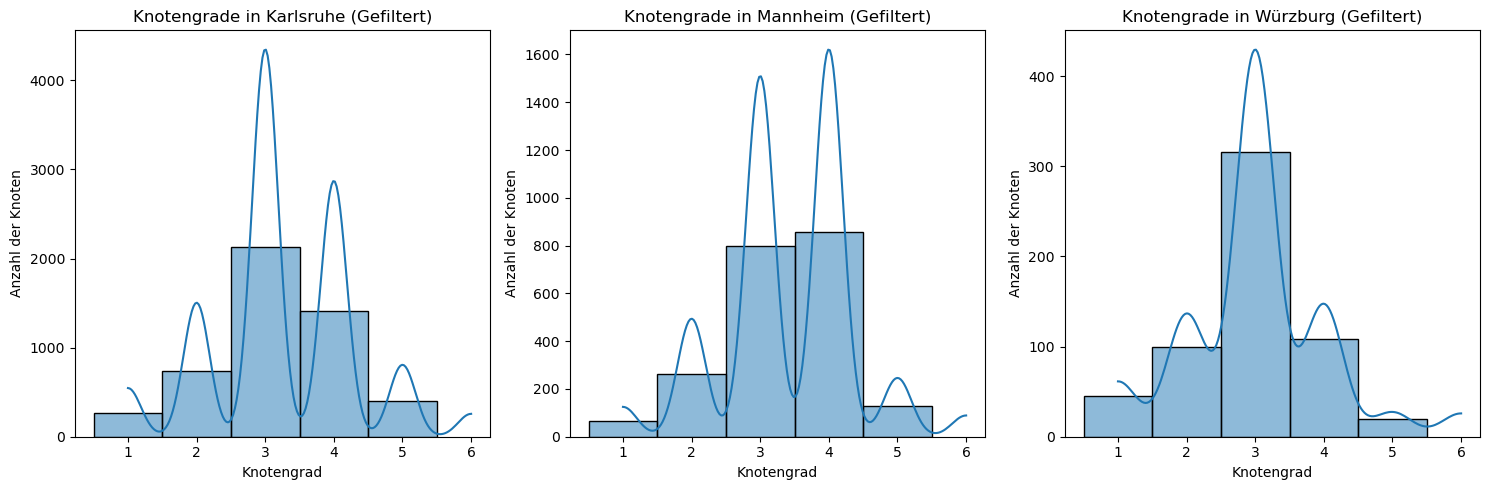

In [7]:
# Bounding-Boxen für die Städte
bounding_boxes = {
    "Mannheim": [(49.4797439235994, 8.459271481182554), (49.49572620679408, 8.472869522710699)],
    "Karlsruhe": [(49.00567848315833, 8.388093017247659), (49.02507245712048, 8.418621377202044)],
    "Würzburg": [(49.79053751531416, 9.92684010036795), (49.79589106529845, 9.935191771430993)]
}

city_folder = "City_data"
files = []
for subfolder in ['city']:
    full_path = os.path.join(city_folder, subfolder)
    files.extend([os.path.join(full_path, file) for file in os.listdir(full_path) if file.endswith(".osm")])

columns = 3
rows = (len(files) + columns - 1) // columns  
fig, axes = plt.subplots(rows, columns, figsize=(15, 5 * rows), squeeze=False)

for idx, file in enumerate(files):
    city_name = os.path.splitext(os.path.basename(file))[0]
    city_data = load_from_all_xml(file)

    if city_name not in bounding_boxes:
        print(f"Keine Bounding-Box für {city_name}, überspringe...")
        continue

    (lat_min, lon_min), (lat_max, lon_max) = bounding_boxes[city_name]

    # Netzwerkgraph für diese Stadt erstellen
    G = nx.Graph()
    
    # Knoten hinzufügen (nur wenn sie innerhalb der Bounding-Box liegen)
    filtered_nodes = city_data[
        (city_data['type'] == 'node') &
        (city_data['latitude'].between(lat_min, lat_max)) &
        (city_data['longitude'].between(lon_min, lon_max))
    ]
    node_ids_in_bbox = set(filtered_nodes['id'])

    for _, row in city_data[city_data['type'] == 'way'].iterrows():
        node_ids = row['node_ids']
        if node_ids is not None:
            # Nur Kanten hinzufügen, wenn beide Knoten innerhalb der Bounding-Box sind
            valid_node_ids = [node_id for node_id in node_ids if node_id in node_ids_in_bbox]
            for i in range(len(valid_node_ids) - 1):
                G.add_edge(valid_node_ids[i], valid_node_ids[i + 1])

    # Knotengrade berechnen (nur für Knoten in der Bounding-Box)
    node_degrees = dict(G.degree())
    
    # Knoten mit Grad > 0 filtern
    filtered_nodes['degree'] = filtered_nodes['id'].map(node_degrees).fillna(0).astype(int)
    filtered_nodes = filtered_nodes[filtered_nodes['degree'] > 0]

    # Knotengrade auf maximal 6 beschränken
    city_node_degrees = filtered_nodes[filtered_nodes['degree'] <= 6]['degree']

    # Position im Gitterlayout berechnen
    row, col = divmod(idx, columns)
    ax = axes[row][col]

    bins = np.arange(1, 7) - 0.5
    
    sns.histplot(city_node_degrees, bins=bins, kde=True, ax=ax)  
    ax.set_title(f"Knotengrade in {city_name} (Gefiltert)")
    ax.set_xlabel("Knotengrad")
    ax.set_ylabel("Anzahl der Knoten")
    ax.set_xticks(range(1, 7))

for idx in range(len(files), rows * columns):
    row, col = divmod(idx, columns)
    axes[row][col].axis('off')

plt.tight_layout()
plt.show()

### Grid-basierte Analyse 

#### For Comparison

In [ ]:
def calculate_grid_density(df_nodes, df_ways, grid_size=200):
    earth_radius = 6371000
    df_nodes['x'] = np.radians(df_nodes['longitude']) * np.cos(np.radians(df_nodes['latitude'])) * earth_radius
    df_nodes['y'] = np.radians(df_nodes['latitude']) * earth_radius

    df_nodes['grid_x'] = (df_nodes['x'] // grid_size).astype(int)
    df_nodes['grid_y'] = (df_nodes['y'] // grid_size).astype(int)

    edges = []
    for _, row in df_ways.iterrows():
        node_ids = row['node_ids']
        if node_ids is not None:
            for i in range(len(node_ids) - 1):
                edges.append((node_ids[i], node_ids[i + 1]))

    edges_df = pd.DataFrame(edges, columns=['node1', 'node2'])
    edges_df = edges_df.merge(df_nodes[['id', 'grid_x', 'grid_y']], left_on='node1', right_on='id', how='left').rename(columns={'grid_x': 'grid_x1', 'grid_y': 'grid_y1'}).drop(columns=['id'])
    edges_df = edges_df.merge(df_nodes[['id', 'grid_x', 'grid_y']], left_on='node2', right_on='id', how='left').rename(columns={'grid_x': 'grid_x2', 'grid_y': 'grid_y2'}).drop(columns=['id'])

    edges_df = edges_df[(edges_df['grid_x1'] == edges_df['grid_x2']) & (edges_df['grid_y1'] == edges_df['grid_y2'])]

    edges_df['grid_x'] = edges_df['grid_x1']
    edges_df['grid_y'] = edges_df['grid_y1']

    edge_density = edges_df.groupby(['grid_x', 'grid_y']).size().reset_index(name='edge_count')
    return edge_density


city_folder = "City_data"
files = []
for subfolder in ['village', 'town', 'city']:
    full_path = os.path.join(city_folder, subfolder)
    files.extend([os.path.join(full_path, file) for file in os.listdir(full_path) if file.endswith(".osm")])
all_densities = []

for file in files:
    city_name = os.path.splitext(os.path.basename(file))[0]
    df = load_from_all_xml(file)
    
    df_nodes = df[df['type'] == 'node']
    df_ways = df[df['type'] == 'way']
    
    # Berechne Knotendichte
    grid_density = calculate_grid_density(df_nodes, df_ways)
    grid_density['city_name'] = city_name
    all_densities.append(grid_density)

output_folder = "Density of various places"
os.makedirs(output_folder, exist_ok=True)

# Kombiniere die Knotendichten aller Städte
df_all_densities = pd.concat(all_densities, ignore_index=True)

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_all_densities, x='city_name', y='edge_count')
plt.title("Vergleich der Netzwerkdichte im 200m-Gitternetz")
plt.xlabel("Stadt")
plt.ylim(0, 25)
plt.ylabel("Netzwerkdichte (Anzahl Kanten pro Gitterzelle)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "Network_density_comparison_200m_Grid.png"))
plt.close()

#### For each file

In [ ]:
def calculate_grid_density(df_nodes, df_ways, grid_size=200):
    earth_radius = 6371000
    df_nodes['x'] = np.radians(df_nodes['longitude']) * np.cos(np.radians(df_nodes['latitude'])) * earth_radius
    df_nodes['y'] = np.radians(df_nodes['latitude']) * earth_radius

    df_nodes['grid_x'] = (df_nodes['x'] // grid_size).astype(int)
    df_nodes['grid_y'] = (df_nodes['y'] // grid_size).astype(int)

    edges = []
    for _, row in df_ways.iterrows():
        node_ids = row['node_ids']
        if node_ids is not None:
            for i in range(len(node_ids) - 1):
                edges.append((node_ids[i], node_ids[i + 1]))

    edges_df = pd.DataFrame(edges, columns=['node1', 'node2'])
    edges_df = edges_df.merge(df_nodes[['id', 'grid_x', 'grid_y']], left_on='node1', right_on='id', how='left').rename(columns={'grid_x': 'grid_x1', 'grid_y': 'grid_y1'}).drop(columns=['id'])
    edges_df = edges_df.merge(df_nodes[['id', 'grid_x', 'grid_y']], left_on='node2', right_on='id', how='left').rename(columns={'grid_x': 'grid_x2', 'grid_y': 'grid_y2'}).drop(columns=['id'])

    edges_df = edges_df[(edges_df['grid_x1'] == edges_df['grid_x2']) & (edges_df['grid_y1'] == edges_df['grid_y2'])]

    edges_df['grid_x'] = edges_df['grid_x1']
    edges_df['grid_y'] = edges_df['grid_y1']

    edge_density = edges_df.groupby(['grid_x', 'grid_y']).size().reset_index(name='edge_count')
    return edge_density

def plot_grid_density(grid_density, city_name, output_folder):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=grid_density,
        x='grid_x', y='grid_y',
        size='edge_count', sizes=(10, 200),
        hue='edge_count', palette='viridis',
        alpha=0.7
    )
    plt.title(f"Netzwerkdichte im 200m-Gitternetz von {city_name}")
    plt.xlabel("Gitter x-Koordinate")
    plt.ylabel("Gitter y-Koordinate")
    plt.legend(title='Anzahl Kanten')
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, f"Network_density_scatter_200m_Grid_{city_name}.png"))
    plt.close()

def plot_specific_grids(grid_density, city_name, output_folder):
    plt.figure(figsize=(10, 6))

    sns.scatterplot(
        data=grid_density,
        x='grid_x', y='grid_y',
        size='edge_count', sizes=(10, 200),
        hue='edge_count', palette='viridis',
        alpha=0.7
    )

    specific_grids = grid_density[grid_density['edge_count'].isin([5, 60])]
    
    if not specific_grids.empty:
        sns.scatterplot(
            data=specific_grids,
            x='grid_x', y='grid_y',
            hue='edge_count', palette={5: 'blue', 60: 'red'},
            size='edge_count', sizes=(100, 300),
            edgecolor='black',
            alpha=1,
            legend=False
        )

    plt.title(f"Netzwerkdichte mit markierten Grid-Zellen (5 & 60 Kanten) - {city_name}")
    plt.xlabel("Gitter x-Koordinate")
    plt.ylabel("Gitter y-Koordinate")
    plt.legend(title='Anzahl Kanten')
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, f"Network_density_marked_5_60_{city_name}.png"))
    plt.close()


city_folder = "City_data"
output_folder = "Density of various places"
os.makedirs(output_folder, exist_ok=True)

for subfolder in ['city']:
    full_path = os.path.join(city_folder, subfolder)
    files = [os.path.join(full_path, file) for file in os.listdir(full_path) if file.endswith(".osm")]

    for file in files:
        city_name = os.path.splitext(os.path.basename(file))[0]
        df = load_from_all_xml(file)

        df_nodes = df[df['type'] == 'node']
        df_ways = df[df['type'] == 'way']

        grid_density = calculate_grid_density(df_nodes, df_ways)

        city_output_folder = os.path.join(output_folder, city_name)
        os.makedirs(city_output_folder, exist_ok=True)

        plot_grid_density(grid_density, city_name, city_output_folder)

        plot_specific_grids(grid_density, city_name, city_output_folder)


### Kernel-basierte Analyse

In [ ]:
def calculate_kernel_density(df_nodes, df_ways):
    earth_radius = 6371000
    df_nodes['x'] = np.radians(df_nodes['longitude']) * np.cos(np.radians(df_nodes['latitude'])) * earth_radius
    df_nodes['y'] = np.radians(df_nodes['latitude']) * earth_radius

    edges = []
    for _, row in df_ways.iterrows():
        node_ids = row['node_ids']
        if node_ids is not None:
            for i in range(len(node_ids) - 1):
                edges.append((node_ids[i], node_ids[i + 1]))

    edges_df = pd.DataFrame(edges, columns=['node1', 'node2'])
    edges_df = edges_df.merge(df_nodes[['id', 'x', 'y']], left_on='node1', right_on='id', how='left').rename(columns={'x': 'x1', 'y': 'y1'}).drop(columns=['id'])
    edges_df = edges_df.merge(df_nodes[['id', 'x', 'y']], left_on='node2', right_on='id', how='left').rename(columns={'x': 'x2', 'y': 'y2'}).drop(columns=['id'])    

    edges_df['x'] = (edges_df['x1'] + edges_df['x2']) / 2
    edges_df['y'] = (edges_df['y1'] + edges_df['y2']) / 2

    return edges_df[['x', 'y']]

city_folder = "City_data"
output_folder = "Density of various places"
os.makedirs(output_folder, exist_ok=True)

files = []
for subfolder in ['village', 'town', 'city']:
    full_path = os.path.join(city_folder, subfolder)
    files = [os.path.join(full_path, file) for file in os.listdir(full_path) if file.endswith(".osm")]

    for file in files:
        city_name = os.path.splitext(os.path.basename(file))[0]
        df = load_from_all_xml(file)

        df_nodes = df[df['type'] == 'node']
        df_ways = df[df['type'] == 'way']

        density_points = calculate_kernel_density(df_nodes, df_ways)

        city_output_folder = os.path.join(output_folder, city_name)
        os.makedirs(city_output_folder, exist_ok=True)

        plt.figure(figsize=(10, 6))
        sns.kdeplot(
            data=density_points,
            x='x', y='y',
            fill=True, common_norm=False, alpha=0.5
        )
        plt.title(f"Kernel-Dichteschätzung der Netzwerkdichte in {city_name}")
        plt.xlabel("x (in Metern)")
        plt.ylabel("y (in Metern)")
        plt.tight_layout()
        output_file = os.path.join(city_output_folder, f"Network_density_kde_{city_name}.png")
        plt.savefig(output_file)
        plt.close()

## Auswirkungen von wichtigsten Kreuzungen und Straßen

In [ ]:
def create_graph_for_centrality(df):
    G = nx.Graph()
    
    # Knoten mit Positionsdaten hinzufügen
    for index, row in df[df['type'] == 'node'].iterrows():  
        G.add_node(row['id'], pos=(row['longitude'], row['latitude']))

    # Kanten hinzufügen
    for index, way in df[df['type'] == 'way'].iterrows():
        node_ids_list = way['node_ids']
        if node_ids_list is not None:
            filtered_node_ids_list = [node_id for node_id in node_ids_list if G.has_node(node_id)]
            if len(filtered_node_ids_list) > 1:
                for i in range(len(filtered_node_ids_list) - 1):
                    G.add_edge(filtered_node_ids_list[i], filtered_node_ids_list[i + 1])

    largest_component = max(nx.connected_components(G), key=len)
    G = G.subgraph(largest_component).copy()

    return G  

def calculate_centrality_indices(G):
    degree_centrality = nx.degree_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)

    return {
        'Degree_centrality': degree_centrality,
        'Closeness_centrality': closeness_centrality,
        'Betweenness_centrality': betweenness_centrality,
    }

def visualize_centrality(G, centrality, title, output_folder):
    pos = nx.get_node_attributes(G, 'pos')
    plt.figure(figsize=(10, 7))

    nodes = nx.draw_networkx_nodes(G, pos, node_size=5, cmap=plt.cm.plasma,
                                   node_color=list(centrality.values()), alpha=0.8)
    edges = nx.draw_networkx_edges(G, pos, edge_color='grey', alpha=0.5)

    # Hinzufügen der Farbskala
    cbar = plt.colorbar(nodes)
    cbar.set_label('Centrality Value')

    plt.title(title)
    plt.axis('off')
    plt.savefig(os.path.join(output_folder, f"{title.replace(' ', '_')}.png"))
    plt.close()

def get_top_betweennes_centrality_nodes(centrality, top_n):
    return sorted(centrality.items(), key=lambda item: item[1], reverse=True)[:top_n]

def get_top_closeness_centrality_nodes(centrality, top_n):
    return sorted(centrality.items(), key=lambda item: item[1], reverse=True)[:top_n]

def calculate_average_shortest_path_length(G):
    if not nx.is_connected(G):
        G = G.subgraph(max(nx.connected_components(G), key=len)).copy()
    return nx.average_shortest_path_length(G)

def calculate_number_of_components(G):
    return nx.number_connected_components(G)

def remove_nodes(G, nodes_to_remove):
    G_removed = G.copy()
    G_removed.remove_nodes_from(nodes_to_remove)
    return G_removed

def visualize_centrality_comparison(G_original, G_removed, centrality_original, centrality_removed, title, output_folder):
    pos = nx.get_node_attributes(G_original, 'pos')
    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.title(f"Original {title}")
    nx.draw(G_original, pos, node_size=10, cmap=plt.cm.plasma,
            node_color=list(centrality_original.values()), alpha=0.8, with_labels=False, edge_color='grey')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title(f"After Removal {title}")
    nx.draw(G_removed, pos, node_size=10, cmap=plt.cm.plasma,
            node_color=list(centrality_removed.values()), alpha=0.8, with_labels=False, edge_color='grey')
    plt.axis('off')

    plt.savefig(os.path.join(output_folder, f"{title.replace(' ', '_')}_comparison.png"))
    plt.close()

def visualize_comparison_metrics(city_names, original_counts, new_counts, metric_name, output_folder, filename):
    x = range(len(city_names))
    plt.figure(figsize=(10, 5))
    plt.bar(x, original_counts, width=0.4, label=f'Original {metric_name}', align='center')
    plt.bar(x, new_counts, width=0.4, label=f'New {metric_name}', align='edge')
    plt.xticks(x, city_names, rotation=45)
    plt.ylabel(metric_name)
    plt.title(f'Comparison of {metric_name}')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, f"{filename}.png"))
    plt.close()

### Darstellung der Zentralitäten pro Stadt

In [ ]:
city_folder = "City_data"
output_base_folder = "Node centrality"

collected_data = []

top_n_map = {
    'village': 10,
    'town': 20,
    'city': 30
}

for subfolder in ['village', 'town']:
    full_path = os.path.join(city_folder, subfolder)
    files = [os.path.join(full_path, file) for file in os.listdir(full_path) if file.endswith(".osm")]
    top_n = top_n_map[subfolder]
    for file_path in files:
        city_name = os.path.splitext(os.path.basename(file_path))[0]
        output_folder = os.path.join(output_base_folder, city_name)
        os.makedirs(output_folder, exist_ok=True)
        print(f"Processing {city_name}...") 

        df = load_from_all_xml(file_path)
        G = create_graph_for_centrality(df)
        centrality_indices = calculate_centrality_indices(G)

        top_nodes_between = get_top_betweennes_centrality_nodes(centrality_indices['Betweenness_centrality'], top_n=top_n)
        top_nodes_close = get_top_closeness_centrality_nodes(centrality_indices['Closeness_centrality'], top_n=top_n)
        for node_id, centrality_value in top_nodes_between:
            collected_data.append({'city': city_name, 'node_id': node_id, 'Betweenness_centrality': centrality_value})

        for node_id, centrality_value in top_nodes_close:
            collected_data.append({'city': city_name, 'node_id': node_id, 'Closeness_centrality': centrality_value})

        for centrality_name, centrality_values in centrality_indices.items():
            visualize_centrality(G, centrality_values, centrality_name.replace("_", " ").title(), output_folder)

top_nodes_df = pd.DataFrame(collected_data)

### Vergleich vor und nach Löschen der Top-Knoten (Betweenness und Closeness)

In [ ]:
# Hauptlogik
city_folder = "City_data"
output_base_folder = "Node centrality"

city_names = []
original_component_counts = []
new_component_counts = []
original_asp_lengths = []
new_asp_lengths = []

top_n_map = {
    'village': 10,
    'town': 20,
    'city': 30
}

for subfolder in ['village', 'town', 'city']:
    full_path = os.path.join(city_folder, subfolder)
    files = [os.path.join(full_path, file) for file in os.listdir(full_path) if file.endswith(".osm")]
    for file_path in files:
        city_name = os.path.splitext(os.path.basename(file_path))[0]
        output_folder = os.path.join(output_base_folder, city_name)
        os.makedirs(output_folder, exist_ok=True)
        print(f"Processing {city_name}...")    
        df = load_from_all_xml(file_path)

        G = create_graph_for_centrality(df)
        centrality_indices_original = calculate_centrality_indices(G)

        original_component_count = calculate_number_of_components(G)
        original_asp_length = calculate_average_shortest_path_length(G)

        # Top-K Knoten der Betweenness-Zentralität
        top_nodes_between = get_top_betweennes_centrality_nodes(centrality_indices_original['Betweenness_centrality'], top_n=top_n_map[subfolder])
        nodes_to_remove = [node_id for node_id, _ in top_nodes_between]

        G_removed = remove_nodes(G, nodes_to_remove)
        centrality_indices_removed = calculate_centrality_indices(G_removed)

        new_component_count = calculate_number_of_components(G_removed)
        new_asp_length = calculate_average_shortest_path_length(G_removed)

        city_names.append(city_name)
        original_component_counts.append(original_component_count)
        new_component_counts.append(new_component_count)
        original_asp_lengths.append(original_asp_length)
        new_asp_lengths.append(new_asp_length)

        # Visualisierung der zentralen Knoten
        visualize_centrality_comparison(
            G, G_removed,
            centrality_indices_original['Betweenness_centrality'],
            centrality_indices_removed['Betweenness_centrality'],
            'Betweenness Centrality',
            output_folder
        )

# Vergleichsmetriken visualisieren
visualize_comparison_metrics(city_names, original_component_counts, new_component_counts, 
                             'Number of Components', output_base_folder, "Number_of_components_Betweenness")
visualize_comparison_metrics(city_names, original_asp_lengths, new_asp_lengths, 
                             'ASP Lengths', output_base_folder, "ASP_lengths_Betweenness")


In [ ]:
city_folder = "City_data"
output_base_folder = "Node centrality"

city_names = []
original_component_counts = []
new_component_counts = []
original_asp_lengths = []
new_asp_lengths = []

top_n_map = {
    'village': 10,
    'town': 20,
    'city': 30
}

for subfolder in ['village', 'town', 'city']:
    full_path = os.path.join(city_folder, subfolder)
    files = [os.path.join(full_path, file) for file in os.listdir(full_path) if file.endswith(".osm")]
    for file_path in files:
        city_name = os.path.splitext(os.path.basename(file_path))[0]
        output_folder = os.path.join(output_base_folder, city_name)
        os.makedirs(output_folder, exist_ok=True)
        print(f"Processing {city_name}...")    
        df = load_from_all_xml(file_path)

        G = create_graph_for_centrality(df)
        centrality_indices_original = calculate_centrality_indices(G)

        original_component_count = calculate_number_of_components(G)
        original_asp_length = calculate_average_shortest_path_length(G)

        # Top-K Knoten der Closeness-Zentralität
        top_nodes_between = get_top_closeness_centrality_nodes(centrality_indices_original['Closeness_centrality'], top_n=top_n_map[subfolder])
        nodes_to_remove = [node_id for node_id, _ in top_nodes_between]

        G_removed = remove_nodes(G, nodes_to_remove)
        centrality_indices_removed = calculate_centrality_indices(G_removed)

        new_component_count = calculate_number_of_components(G_removed)
        new_asp_length = calculate_average_shortest_path_length(G_removed)

        city_names.append(city_name)
        original_component_counts.append(original_component_count)
        new_component_counts.append(new_component_count)
        original_asp_lengths.append(original_asp_length)
        new_asp_lengths.append(new_asp_length)

        # Visualisierung der zentralen Knoten
        visualize_centrality_comparison(
            G, G_removed,
            centrality_indices_original['Closeness_centrality'],
            centrality_indices_removed['Closeness_centrality'],
            'Closeness Centrality',
            output_folder
        )

# Vergleichsmetriken visualisieren
visualize_comparison_metrics(city_names, original_component_counts, new_component_counts, 
                             'Number of Components', output_base_folder, "Number_of_components_Closeness")
visualize_comparison_metrics(city_names, original_asp_lengths, new_asp_lengths, 
                             'ASP Lengths', output_base_folder, "ASP_lengths_Closeness")
